# Imports

In [1]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
# Dataset fetching
from sklearn.datasets import fetch_openml

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

# pca
from sklearn.decomposition import PCA

# Pipeline utility
from sklearn.pipeline import make_pipeline

# Classifiers: dummy, KNN
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model selection
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV,cross_val_predict
from sklearn.model_selection import learning_curve

# Evaluation metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

# Handwritten Digit Classification

### Dataset

In [2]:
X,y= fetch_openml('mnist_784', version=1,return_X_y=True)
X = X.to_numpy ()
y = y.to_numpy ()

In [4]:
x_train,x_test,y_train,y_test = X[ : 60000], X[60000: ], y[ : 60000 ] , y [ 60000 :]

# Binary Classification

### Change Labels to Binary
- Let us do binary classification with KNN classifier and eventually extend it to Multiclass set-up

In [5]:
# intialize new variable names with all -1
y_train_0= -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 =np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

# Data Visualization in Lower dimention


- Let us apply PCA on the datapoints and reduce the dimentions to 2D and then to 3D.

- This will give us some rough idea about the points in $R^{784}$

- One Interesting thing to look at is the change in the magnitude of the data points before and after applying PCA.

- we use the variables `pipe_pca_2d` for pre-processing the samples alone and `pipe_clf_pca_2d` for classification.

In [6]:
pipe_pca_2d = make_pipeline(MinMaxScaler(),PCA(n_components=2))
x_train_pca_2d =pipe_pca_2d.fit_transform(x_train)

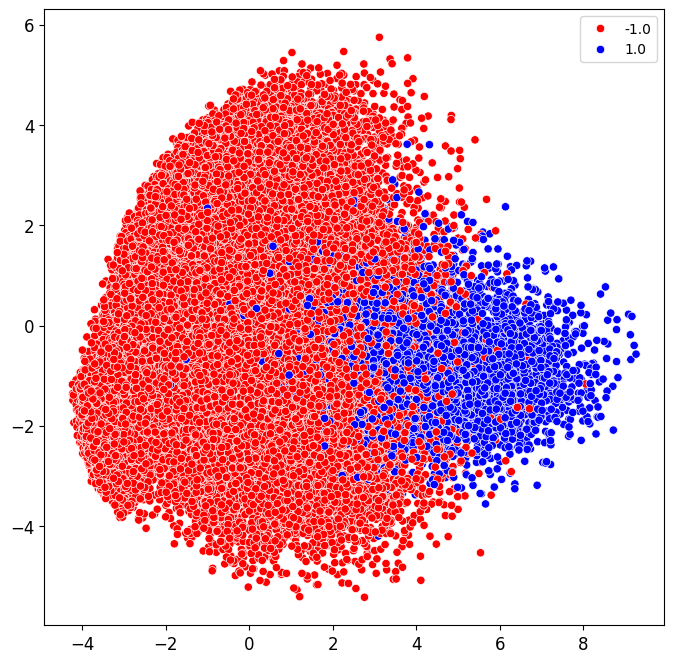

In [7]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['r','b'])
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_train_pca_2d[:,0], y=x_train_pca_2d[:,1], hue=y_train_0, palette=cmap)
plt.show()

# Projection in 3D using PCA

In [8]:
pipe_pca_3d= make_pipeline(MinMaxScaler(),PCA(n_components=3))
x_train_pca_3d =pipe_pca_3d.fit_transform(x_train)

In [13]:
# I AM GETTING ERROR IN THIS CELL

import plotly.express as px

fig = px.scatter_3d(
    x=x_train_pca_3d[:, 0],
    y=x_train_pca_3d[:, 1],
    z=x_train_pca_3d[:, 2],
    color=y_train_0,
    color_discrete_map=cmap,
    opacity=0.5,
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# KNN Classifier

### Algorithm

1. Set k to desired value, i.e. how many neighbours should be allowed to participate in prediction.
2. Calculate the distance between the new example and every example from the data. Thus create a distance vector.
3. Get indices of nearest k neighbours
4. Get the labels of the selected k entries
5. If it is a classification task, return the majority class by computing mode
   of the k labels.

<br> 

- To understand the working of sklearn built-in functions, we first create a KNN classifier model with k = 3 and consider a smaller number
of samples from training and testing set.

- The KNeighborsClassifier creates a classifier instance. There are many optional arguments such as n_neighbors, metric,
weights, ... that can be set to suitable values while creating an instance.

In [14]:
# creating a new pipeline for classifer
pipe_clf_pca_2d=make_pipeline(pipe_pca_2d,KNeighborsClassifier(n_neighbors=3))

- Let us train the model with 10 samples from training set (i.e., we are just putting 10 datapoints in the metric space, not building any
parameterized model).

- Then test the model with 10 datapoints from test set

In [15]:
index_neg =np.argsort(y_train_0) [:5] #index of positive samples
index_pos = np.argsort(y_train_0)[-1 :- 6 :- 1] # index of negative samples

### Sanity Check

In [16]:
#ensure first 10 samples are mix of both classes
print("Pos_classes:", y_train_0[index_pos ])
print("Neg_classes:", y_train_0[index_neg])

Pos_classes: [1. 1. 1. 1. 1.]
Neg_classes: [-1. -1. -1. -1. -1.]


In [17]:
# create a small dataset
x = np.vstack((x_train[index_pos, : ],x_train[index_neg,: ]))
print(x.shape)
y = np.hstack ((y_train_0[index_pos],y_train_0 [index_neg]))
print(y.shape)

(10, 784)
(10,)


In [18]:
# Let's fit model with new training set
pipe_clf_pca_2d.fit(x, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [19]:
# for visualization
x_reduced = pipe_clf_pca_2d[0].transform(x)

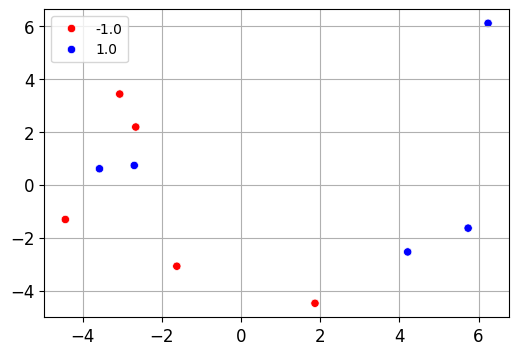

In [20]:
cmap = ListedColormap(['r','b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x = x_reduced[:,0], y=x_reduced[:, 1], marker='o', hue=y, palette=cmap)
plt.grid(True)
plt.show()

Test labels: [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


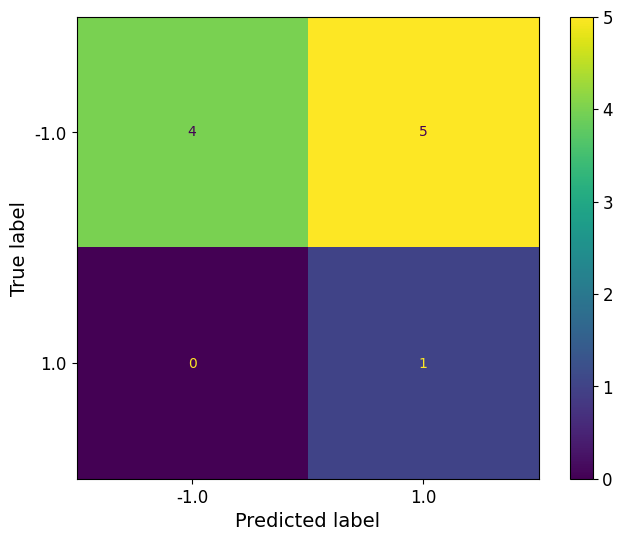

In [21]:
y_hat_0= pipe_clf_pca_2d.predict(x_test[:10,:])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10],y_hat_0)
print('Test labels:',y_test_0[:10])
plt.show()


- We can see that there are more FP's (since 9 out of 10 actual labels are negative)

- Let us display both the training points and testing points with their predictions

- We can visually validate the reason behind the performance.

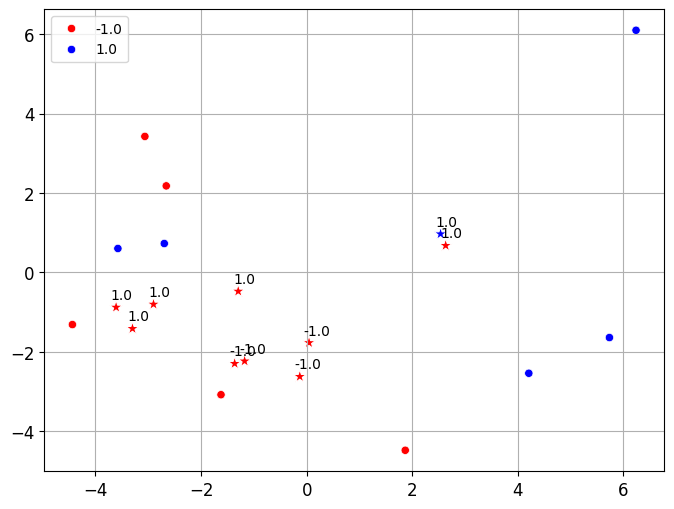

In [22]:
cmap = ListedColormap(['r','b'])
plt.figure(figsize=(8,6))
sns.scatterplot(x = x_reduced[:,0], y=x_reduced[:,1], marker='o', hue=y, palette=cmap)

# test points
x_test_reduced = pipe_clf_pca_2d[0].transform(x_test[:10,: ])
sns.scatterplot(x=x_test_reduced[:,0], y=x_test_reduced[:, 1], s=100, marker='*', hue=y_test_0[: 10], palette=cmap, legend=None)
#Plot the test points and annotate the points with their predictions
dx,dy =- 0.1,0.2
for i in range(10):
    plt.annotate(str(y_hat_0[i]), xy=(x_test_reduced[i, 0]+dx, x_test_reduced[i, 1]+dy))

#show grid
plt.grid(True)
plt.show()


- It would be much better if we know the distance of 3 neighbours for each testing point.

- Let us display the distance and connectivity of neighbours to the test datapoint(s) using the class NearestNeighbors.

- In fact, KNeighborsClassifier calls NearestNeighbors class internally to compute all these distance.

In [23]:
from sklearn.neighbors import NearestNeighbors
neighbours = NearestNeighbors(n_neighbors=3)
neighbours.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

Which are the first three closest neighbours to the first three in the test set? and how close are they?

In [24]:
dist_neighbours, idx_neighbours = neighbours.kneighbors(
    pipe_pca_2d.transform(x_test[:10]), 3, return_distance=True
)

In [25]:
import statistics


for i in range(3):
    print('Distance: {0}, \nIndex:{1}, \nLabels: {2} \nPrediction: {3}' . format (dist_neighbours[i],
    idx_neighbours [i],
    y[idx_neighbours [i].flatten()],
    statistics.mode(y[idx_neighbours[i]. flatten()])))

Distance: [1.54510433 1.56004731 1.61914472], 
Index:[1 4 6], 
Labels: [ 1.  1. -1.] 
Prediction: 1.0
Distance: [0.95703587 3.33077652 3.39001596], 
Index:[7 1 6], 
Labels: [-1.  1. -1.] 
Prediction: -1.0
Distance: [1.14297879 2.0379748  2.22709669], 
Index:[6 4 1], 
Labels: [-1.  1.  1.] 
Prediction: 1.0


Let us train the model with 10000 samples from training set (i.e., we are just putting 10000 datapoints in the metric space, not building any
parameterized model)

In [26]:
pipe_clf_pca_2d.fit(x_train[:10000],y_train_0[ : 10000])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

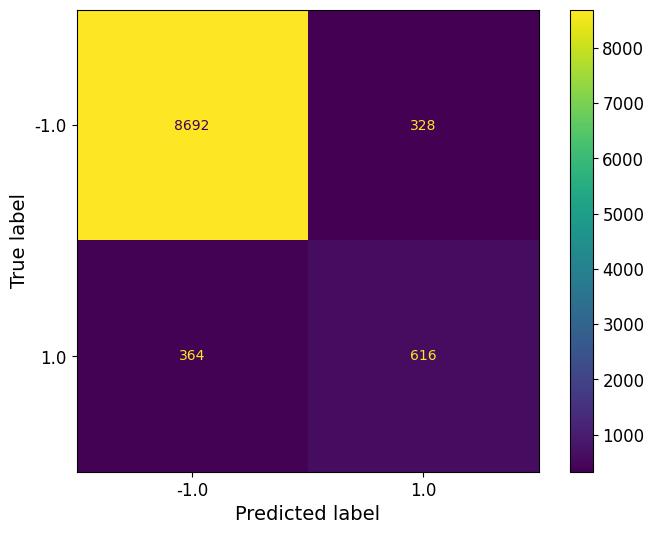

In [27]:
y_hat_0 =pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_0)
plt.show()

In [28]:
print(classification_report(y_test_0,y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000




- Let's vary the n_neighbors from k=1 to 19 and study the performance of the model.

- We use the first 10K samples from training set (you may increase it further upto 60K, take it as an excersise)

In [29]:
from sklearn.metrics import precision_score


precision=[]
for k in range(1,20,2):
    pipe_clf_pca_2d.__n_neighbors=k
    pipe_clf_pca_2d.fit(x_train[:10000],y_train_0[: 10000])
    y_hat_0 = pipe_clf_pca_2d.predict(x_test)
    precision.append(precision_score(y_test_0,y_hat_0))

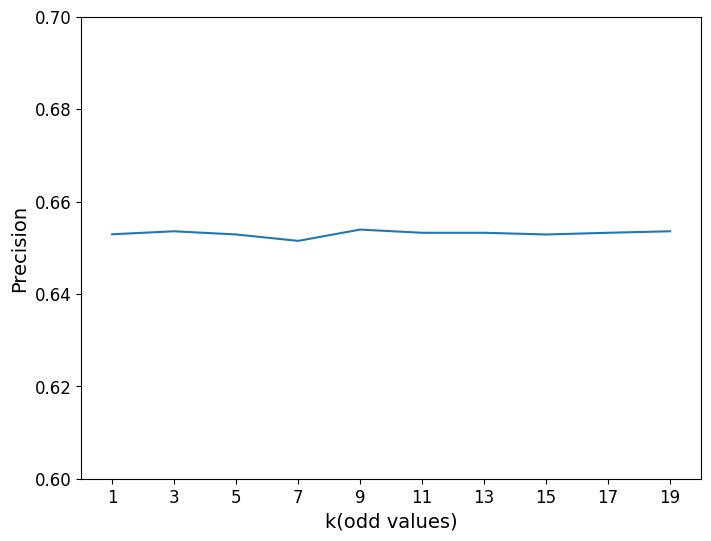

In [30]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,20,2),precision)
plt.xlim((0,20))
plt.ylim((0.6,0.7))
plt.xlabel('k(odd values)')
plt.ylabel('Precision')
plt.xticks(ticks=np.arange(1,20, 2), labels=np.arange(1, 20, 2))
plt.show()

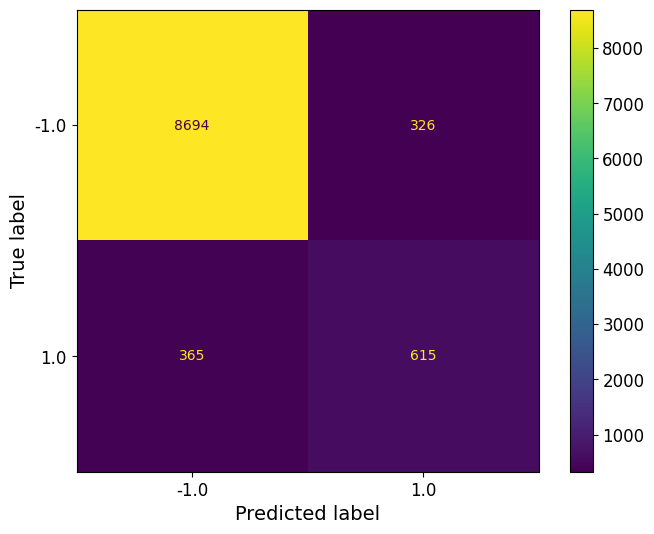

In [31]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_0)

# Going Without PCA

- Let us use KNN classifier with all the features in the training samples.Hoping
  that it increases the performance of the model (of course at the cost of computation)

- Let's search for K by using cross validation.

- Note: It takes about 20 minutes for entire computation.

In [32]:
pipe_knn= make_pipeline(MinMaxScaler(),
KNeighborsClassifier(n_neighbors=1))

In [34]:
grid_k = {'kneighborsclassifier__n_neighbors': [1, 3,5, 7, 9, 11]}
cv = GridSearchCV(pipe_knn, param_grid=grid_k, scoring='precision',cv=5)
cv.fit(x_train,y_train_0)
print(cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11]},
             scoring='precision')


In [35]:
print(cv.cv_results_)

{'mean_fit_time': array([1.53149939, 0.84521704, 1.0661706 , 0.99704604, 1.10963879,
       0.94379067]), 'std_fit_time': array([1.30182831, 0.01208458, 0.29373864, 0.14082678, 0.20455095,
       0.05971568]), 'mean_score_time': array([15.24273019, 14.21270428, 16.91430373, 16.45104041, 17.84175477,
       17.17268929]), 'std_score_time': array([1.60059268, 0.12501421, 2.60625035, 1.08827088, 1.46989396,
       1.81475616]), 'param_kneighborsclassifier__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kneighborsclassifier__n_neighbors': 1}, {'kneighborsclassifier__n_neighbors': 3}, {'kneighborsclassifier__n_neighbors': 5}, {'kneighborsclassifier__n_neighbors': 7}, {'kneighborsclassifier__n_neighbors': 9}, {'kneighborsclassifier__n_neighbors': 11}], 'split0_test_score': array([0.97920133, 0.98493724, 0.98166667, 0.98086522, 0.97921862,
       0.97921862]), 'sp

- Best value for k is **7**

In [39]:
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=7))

### Performance on test set

In [41]:
y_hat_0 = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_0)
plt.show()

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Multi-Class Classification

- Extending KNN classifier to multi-class problem is quite straightforward.

In [40]:
print(pipe_knn)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])


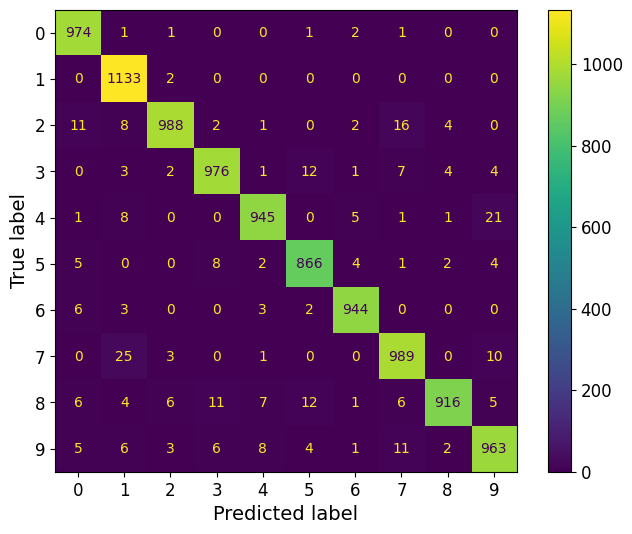

In [42]:
pipe_knn.fit(x_train,y_train)
y_hat = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions (y_test,y_hat)
plt.show()

In [43]:
pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [44]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

